In [2]:
import marvin
marvin.config.setRelease('DR16')
import matplotlib.pyplot as plt
import numpy as np
import os.path
from astropy.io import fits
from astropy.table import QTable, Column
import astropy.unitxxxs as u
from scipy.optimize import minimize
import emcee
import corner

In [3]:
# Physical Constants
c = 3E5 # km * s ^1
h = 1 # reduced hubble constant
H_0 =  100 * h # km * s^-1 * Mpc^-1

In [4]:
# Used files
DTable1 = QTable.read('Master_Table.txt',format='ascii.commented_header')
DTable2 = QTable.read('DRPall-master_file.txt',format='ascii.ecsv')
# Get the Mass of stars & redshifts & angular resolution of r50
m = DTable1['NSA_Mstar'].data
rat = DTable1['NSA_ba'].data
phi = DTable1['NSA_phi'].data
z = DTable2['redshift'].data
r50_ang = DTable2['nsa_elpetro_th50_r'].data

In [5]:
from Rotation_Curve_Functions import vel_b,v_d,vel_h_iso,vel_h_NFW,vel_h_Burket,v_co_iso,v_co_iso_nb,v_co_NFW,v_co_NFW_nb,v_co_Burket,v_co_Burket_nb
from Velocity_Map_Functions import rot_incl_iso, rot_incl_iso_nb, rot_incl_NFW, rot_incl_NFW_nb, rot_incl_bur, rot_incl_bur_nb, loglikelihood_iso, loglikelihood_iso_nb, loglikelihood_NFW, loglikelihood_NFW_nb, loglikelihood_bur, loglikelihood_bur_nb, nloglikelihood_iso, nloglikelihood_iso_nb, nloglikelihood_NFW, nloglikelihood_NFW_nb, nloglikelihood_bur, nloglikelihood_bur_nb

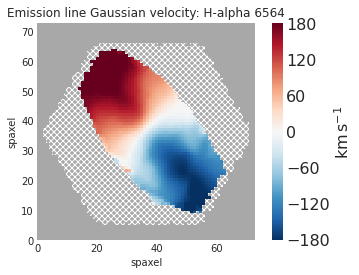

In [6]:
# Testing on object 7443-12705
# Obtaining the object
my_cube_5 = marvin.tools.Maps('7443-12705')
gas_vfield_5 = my_cube_5.emline_gvel_ha_6564
gas_vfield_5.plot()
gas_ivar_5 = gas_vfield_5.ivar

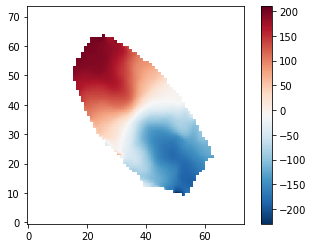

In [7]:
import numpy.ma as ma
v_mask = ma.array(gas_vfield_5.data,mask=gas_vfield_5.mask)
plt.imshow(v_mask,origin='lower',cmap='RdBu_r')
plt.colorbar()

In [8]:
# Obtain the effective radius for plate IFU 7443-12705
r50_spec = 0
z_spec = 0
for i in range(len(DTable2)):
    if DTable2['MaNGA_plate'][i] == 7443 and DTable2['MaNGA_IFU'][i] == 12705:
        r50_spec = r50_ang[i]
        z_spec = z[i]

# Obtain stellar mass of 7443-12705
m_spec = 0
for i in range(len(DTable1)):
    if DTable1['MaNGA_plate'][i] == 7443 and DTable1['MaNGA_IFU'][i] == 12705:
        m_spec = m[i]
print(np.log10(m_spec))

# Obtain inclination
incl = 0
for i in range(len(DTable1)):
    if DTable1['MaNGA_plate'][i] == 7443 and DTable1['MaNGA_IFU'][i] == 12705:
        incl = np.arccos(rat[i])
print(incl)

# Obtain phi
ph = 0
for i in range(len(DTable1)):
    if DTable1['MaNGA_plate'][i] == 7443 and DTable1['MaNGA_IFU'][i] == 12705:
        ph = phi[i]*np.pi/180
print(ph)

#  Calculate the recession velocity for 7443-12705
v_rec = z_spec * c # km/s

# Using Hubble's Law to calculate distance [kpc] for 7443-12705
d = v_rec/H_0 # Mpc
d *= 1E3 # kpc

# Using Small Angle Formula to calculate the actual value of r50 [kpc] for 7443-12705
theta = r50_spec/206265 # radian
r50 = theta * d # kpc
print(r50)
print(z_spec)
print(d)
scale_spec = 0.5*(193420.5)/206265
print(scale_spec)
gal_shape = [74,74]

10.353951647911828
1.2005955251079776
0.6421872084106552
6.912622583739364
0.0644735
193420.5
0.46886408261217366


Isothermal Fitting

[WARNING]: invalid value encountered in double_scalars (RuntimeWarning)
[WARNING]: divide by zero encountered in double_scalars (RuntimeWarning)
[WARNING]: invalid value encountered in double_scalars (RuntimeWarning)
[WARNING]: divide by zero encountered in log (RuntimeWarning)
[WARNING]: Warning: converting a masked element to nan. (UserWarning)


---------------------------------------------------
      fun: masked
 hess_inv: <10x10 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 9.16280551e+03,  5.77187528e+01, -6.18725952e+05, -3.75321836e+04,
       -5.22628710e+03,  4.74311838e+04, -1.37421420e+06, -7.80540864e+04,
        9.79953455e+18,  1.06276312e+19])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 22
      nit: 0
     njev: 2
   status: 2
  success: False
        x: array([  0.4       , 127.        ,  10.35395165,   4.        ,
       150.        ,  15.        ,   1.20059553,   0.64218721,
        37.        ,  37.        ])


(<Figure size 432x288 with 2 Axes>,
 <AxesSubplot:title={'center':'Emission line Gaussian velocity: H-alpha 6564'}, xlabel='spaxel', ylabel='spaxel'>)

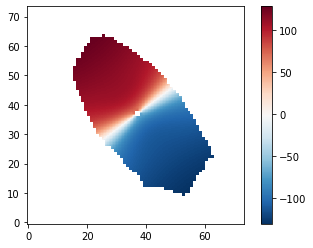

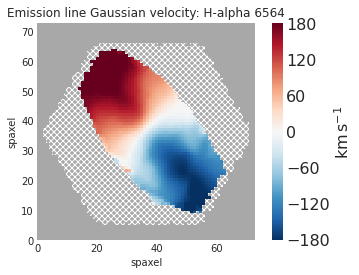

In [9]:
# Initial guesses
param_bounds_iso = [[0.2, 1],  # Scale Factor [unitless]
                [0.001, 1000],  # Bulge Scale Velocity [km/s]
                [np.log10(m_spec), 13],  # Disk mass [log(Msun)]
                [0.1, 20],  # Disk radius [kpc]
                [50, 500],  # Velocity at infinity [km/s]
                [0.1, 100],  # Halo radius [kpc]
                [0.1,np.pi/2], # Inclination angle
                [-np.pi/2,np.pi/2],# Phase angle
                [0.1,40],#center_x
                [0.1,40]] #center_y
p0_iso = [0.4,127,10, 4, 150, 15, incl,ph,37,37]
bestfit_iso = minimize(nloglikelihood_iso, p0_iso, args=(scale_spec, gal_shape, v_mask, gas_ivar_5),bounds=param_bounds_iso)
print('---------------------------------------------------')
print(bestfit_iso)
# Plotting Isothermal
bestfit_param_iso = [bestfit_iso.x[0],bestfit_iso.x[1],bestfit_iso.x[2],bestfit_iso.x[3],bestfit_iso.x[4],bestfit_iso.x[5],bestfit_iso.x[6],bestfit_iso.x[7],bestfit_iso.x[8],bestfit_iso.x[9]]
model_map_iso = rot_incl_iso(gal_shape, scale_spec, bestfit_param_iso)
mask_model_map_iso = ma.array(model_map_iso,mask=gas_vfield_5.mask)
plt.imshow(mask_model_map_iso,origin='lower',cmap='RdBu_r')
plt.colorbar()
gas_vfield_5.plot()

In [10]:
# Chi-square calculation
chi_square_iso = np.nansum((v_mask - mask_model_map_iso) ** 2 * gas_ivar_5)
chi_square_iso/(1564-8)

888.0807707115797

Isothermal Fitting w/o Bulge

[WARNING]: invalid value encountered in double_scalars (RuntimeWarning)
[WARNING]: invalid value encountered in double_scalars (RuntimeWarning)
[WARNING]: divide by zero encountered in log (RuntimeWarning)
[WARNING]: Warning: converting a masked element to nan. (UserWarning)


---------------------------------------------------
      fun: 87531.82433076928
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.1670635 ,  0.32305249, -3.34402747, -0.14842954, -7.94243534,
       -3.32220223, -3.02243254,  2.09547562])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 2826
      nit: 232
     njev: 314
   status: 0
  success: True
        x: array([1.26277977e+01, 8.02741183e+00, 5.00000000e+02, 3.72266504e-01,
       1.98712513e-01, 7.21731025e-01, 3.62309746e+01, 3.64908209e+01])


(<Figure size 432x288 with 2 Axes>,
 <AxesSubplot:title={'center':'Emission line Gaussian velocity: H-alpha 6564'}, xlabel='spaxel', ylabel='spaxel'>)

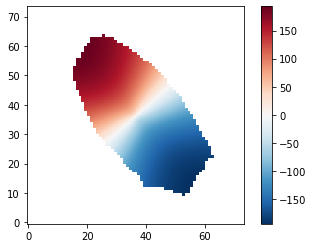

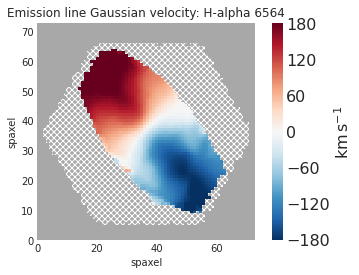

In [11]:
# Initial guesses
param_bounds_iso_nb = [[8, 13],  # Disk mass [log(Msun)]
                [0.001, 20],  # Disk radius [kpc]
                [50, 500],  # Velocity at infinity [km/s]
                [0.1, 100],  # Halo radius [kpc]
                [0.1,np.pi/2], # Inclination angle
                [-np.pi/2,np.pi/2],# Phase angle
                [0.1,40],#center_x
                [0.1,40]] #center_yX
p0_iso_nb = [10, 4, 150, 15, incl, ph, 37, 37]
bestfit_iso_nb = minimize(nloglikelihood_iso_nb, p0_iso_nb, args=(scale_spec, gal_shape, v_mask, gas_ivar_5),bounds=param_bounds_iso_nb)
print('---------------------------------------------------')
print(bestfit_iso_nb)
# Plotting Isothermal
bestfit_param_iso_nb = [bestfit_iso_nb.x[0],bestfit_iso_nb.x[1],bestfit_iso_nb.x[2],bestfit_iso_nb.x[3],bestfit_iso_nb.x[4],bestfit_iso_nb.x[5],bestfit_iso_nb.x[6],bestfit_iso_nb.x[7]]
model_map_iso_nb = rot_incl_iso_nb(gal_shape, scale_spec, bestfit_param_iso_nb)
mask_model_map_iso_nb= ma.array(model_map_iso_nb,mask=gas_vfield_5.mask)
plt.imshow(mask_model_map_iso_nb,origin='lower',cmap='RdBu_r')
plt.colorbar()
gas_vfield_5.plot()

In [12]:
# Chi-square calculation
chi_square_iso_nb = np.nansum((v_mask - mask_model_map_iso_nb) ** 2 * gas_ivar_5)
chi_square_iso_nb/(1564-8)

110.8034207801135

NFW Fitting

[WARNING]: invalid value encountered in double_scalars (RuntimeWarning)
[WARNING]: divide by zero encountered in double_scalars (RuntimeWarning)
[WARNING]: invalid value encountered in double_scalars (RuntimeWarning)
[WARNING]: Extremely bad integrand behavior occurs at some points of the (IntegrationWarning)
[WARNING]: divide by zero encountered in log (RuntimeWarning)


---------------------------------------------------
      fun: 6948884976.714188
 hess_inv: <10x10 LbfgsInvHessProduct with dtype=float64>
      jac: array([-5.10546612e+04, -3.21585887e+02, -1.83255317e+06, -5.39031116e+04,
       -4.59572410e+08, -5.86828867e+04,  1.68641283e+06, -5.46600900e+04,
        9.79953455e+18,  1.06276312e+19])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 231
      nit: 0
     njev: 21
   status: 2
  success: False
        x: array([4.00000000e-01, 1.27000000e+02, 1.03539516e+01, 4.00000000e+00,
       1.00000000e-03, 1.50000000e+01, 1.20059553e+00, 6.42187208e-01,
       3.70000000e+01, 3.70000000e+01])


(<Figure size 432x288 with 2 Axes>,
 <AxesSubplot:title={'center':'Emission line Gaussian velocity: H-alpha 6564'}, xlabel='spaxel', ylabel='spaxel'>)

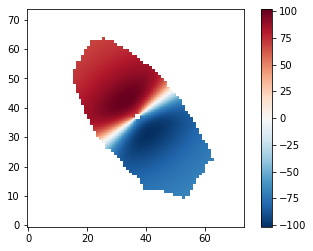

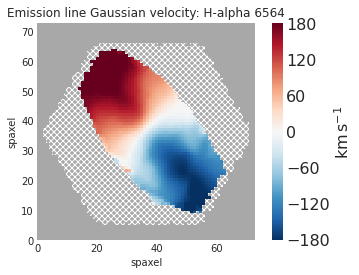

In [13]:
# Initial guesses
param_bounds_NFW = [[0.2, 1],  # Scale Factor [unitless]
                [0.001, 1000],  # Bulge Scale Velocity [km/s]
                [np.log10(m_spec), 13],  # Disk mass [log(Msun)]
                [0.1, 20],  # Disk radius [kpc]
                [0.00001, 0.01],  # Halo density [Msun/pc^2]
                [0.1, 100],  # Halo radius [kpc]
                [0.1,np.pi/2], # Inclination angle
                [-np.pi/2,np.pi/2],# Phase angle
                [0.1,40],#center_x
                [0.1,40]] #center_y
p0_NFW = [0.4,127,10, 4, 0.001, 15, incl,ph,37,37]
bestfit_NFW = minimize(nloglikelihood_NFW, p0_NFW, args=(scale_spec, gal_shape, v_mask, gas_ivar_5),bounds=param_bounds_NFW)
print('---------------------------------------------------')
print(bestfit_NFW)
# Plotting NFW
bestfit_param_NFW = [bestfit_NFW.x[0],bestfit_NFW.x[1],bestfit_NFW.x[2],bestfit_NFW.x[3],bestfit_NFW.x[4],bestfit_NFW.x[5],bestfit_NFW.x[6],bestfit_NFW.x[7],bestfit_NFW.x[8],bestfit_NFW.x[9]]
model_map_NFW = rot_incl_NFW(gal_shape, scale_spec, bestfit_param_NFW)
mask_model_map_NFW= ma.array(model_map_NFW,mask=gas_vfield_5.mask)
plt.imshow(mask_model_map_NFW,origin='lower',cmap='RdBu_r')
plt.colorbar()
gas_vfield_5.plot()

In [14]:
# Chi-square calculation
chi_square_NFW = np.nansum((v_mask - mask_model_map_NFW) ** 2 * gas_ivar_5)
chi_square_NFW/(1564-8)

2190.272671898374

NFW Fitting w/o Bulge

[WARNING]: invalid value encountered in double_scalars (RuntimeWarning)
[WARNING]: invalid value encountered in double_scalars (RuntimeWarning)
[WARNING]: divide by zero encountered in double_scalars (RuntimeWarning)
[WARNING]: Extremely bad integrand behavior occurs at some points of the (IntegrationWarning)
[WARNING]: divide by zero encountered in log (RuntimeWarning)


---------------------------------------------------
      fun: 1728409.2879461888
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.94533428e+06, -4.20606232e+04, -4.77504985e+08, -6.07947769e+04,
        1.57813100e+06, -5.08599446e+04,  3.50737888e+09,  3.50945996e+09])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 189
      nit: 0
     njev: 21
   status: 2
  success: False
        x: array([1.03539516e+01, 4.00000000e+00, 1.00000000e-03, 1.50000000e+01,
       1.20059553e+00, 6.42187208e-01, 3.70000000e+01, 3.70000000e+01])


(<Figure size 432x288 with 2 Axes>,
 <AxesSubplot:title={'center':'Emission line Gaussian velocity: H-alpha 6564'}, xlabel='spaxel', ylabel='spaxel'>)

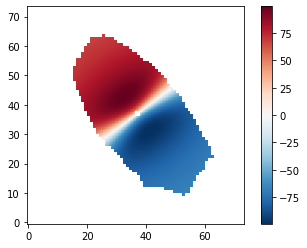

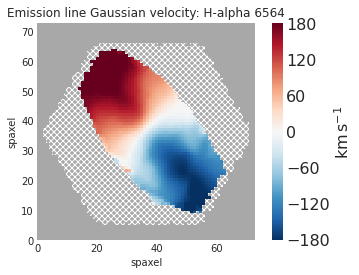

In [15]:
# Initial guesses
param_bounds_NFW_nb = [[np.log10(m_spec), 13],  # Disk mass [log(Msun)]
                [0.1, 20],  # Disk radius [kpc]
                [0.00001, 0.01],  # Halo density [Msun/pc^2]
                [0.1, 100],  # Halo radius [kpc]
                [0.1,np.pi/2], # Inclination angle
                [-np.pi/2,np.pi/2],# Phase angle
                [0.1,40],#center_x
                [0.1,40]] #center_y
p0_NFW_nb = [10, 4, 0.001, 15, incl, ph, 37, 37]
bestfit_NFW_nb = minimize(nloglikelihood_NFW_nb, p0_NFW_nb, args=(scale_spec, gal_shape, v_mask, gas_ivar_5),bounds=param_bounds_NFW_nb)
print('---------------------------------------------------')
print(bestfit_NFW_nb)
# Plotting NFW
bestfit_param_NFW_nb = [bestfit_NFW_nb.x[0],bestfit_NFW_nb.x[1],bestfit_NFW_nb.x[2],bestfit_NFW_nb.x[3],bestfit_NFW_nb.x[4],bestfit_NFW_nb.x[5],bestfit_NFW_nb.x[6],bestfit_NFW_nb.x[7]]
model_map_NFW_nb = rot_incl_NFW_nb(gal_shape, scale_spec, bestfit_param_NFW_nb)
mask_model_map_NFW_nb= ma.array(model_map_NFW_nb,mask=gas_vfield_5.mask)
plt.imshow(mask_model_map_NFW_nb,origin='lower',cmap='RdBu_r')
plt.colorbar()
gas_vfield_5.plot()

In [16]:
# Chi-square calculation
chi_square_NFW_nb = np.nansum((v_mask - mask_model_map_NFW_nb) ** 2 * gas_ivar_5)
chi_square_NFW_nb/(1564-8)

2219.8557699564867